# Fama and French Factor Model: Size Factor #

### Testing the Relevance of Size Factor ###

In [146]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm

# Manipulate Files
import os

# Pretty Notation
from IPython.display import display, Math

In [228]:
# Create the Weights function
def wexp(N, half_life):
    c = np.log(0.5)/half_life
    n = np.array(range(N))
    w = np.exp(c*n)
    return np.flip(w/np.sum(w))

# Create the CAPM 
def CAPM(
    stock_prices: pd.Series, 
    benchmark_prices: pd.Series = sp500['sp_500'], 
    risk_free_rate: pd.Series = rfr['risk_free_rate'], 
    window: int = 252,
    WLS: bool = True,
):

    # Align time series to the same date range
    common_index = stock_prices.index.intersection(benchmark_prices.index).intersection(risk_free_rate.index)
    stock_prices = stock_prices.loc[common_index]
    benchmark_prices = benchmark_prices.loc[common_index]
    risk_free_rate = risk_free_rate.loc[common_index]
    
    # Compute daily returns
    stock_returns = stock_prices.pct_change(1)
    benchmark_returns = benchmark_prices.pct_change(1)
    risk_free_daily = (((1 + (risk_free_rate.div(100)))**(1/360)) - 1)  # Convert annual rate to daily
    
    # Excess returns
    excess_stock = stock_returns - risk_free_daily
    excess_benchmark = benchmark_returns - risk_free_daily

    alphas, betas = [], []

    # Create weights with exponential decay
    weights = window * wexp(window, window/2)
    
    for t in range(window, len(stock_returns)):
        X = excess_benchmark.iloc[t-window:t]
        y = excess_stock.iloc[t-window:t]
        
        if X.isnull().any() or y.isnull().any():
            continue

        if WLS:
            
            # Fit WLS regression
            model = sm.WLS(y, sm.add_constant(X), weights=weights, missing='drop').fit()

        else:

            # Fit OLS regression
            model = sm.OLS(y, sm.add_constant(X), missing='drop').fit()

        # Avoid KeyError by checking if params exist
        params = model.params
        
        alphas.append(params.iloc[0])
        betas.append(params.iloc[1])
            
    parameters = pd.DataFrame({
        'alpha': alphas,
        'beta': betas,
    }, index=stock_returns.index[window+1:])
    
    return parameters

In [73]:
# Get the important data for the Risk Free Rate

rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index, dayfirst=True)

# Get the important data for the S&P500

sp500 = pd.read_csv(r"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index, dayfirst=True)

# Get the data for the Stocks' Betas

betas_df = pd.read_csv(r"..\additional_data\betas.csv")
betas_df = betas_df.set_index('Date')
betas_df.index = pd.to_datetime(betas_df.index)

In [74]:
# Folder Path
folder_path = r"..\stocks"

# Dictionary to store the DataFrames
dataframes = {}

# List all files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        # Full path to the file
        file_path = os.path.join(folder_path, file)
        
        # Read the Excel file
        df = pd.read_csv(file_path)
        df = df.set_index("Date")
        df.index = pd.to_datetime(df.index)

        df = df[['Adjusted_close', 'Market_cap_calculado']]

        df = df.rename(columns={
            'Adjusted_close':'adj_close',
            'Market_cap_calculado':'market_cap',
        })

        # Fill nans
        df['adj_close'] = df['adj_close'].interpolate(method='linear')
        df['market_cap'] = df['market_cap'].interpolate(method='linear')

        df = df.loc['2015-01-01':]

        df.dropna(inplace=True)
        
        if len(df) >= 2000:
            # File name without extension
            file_name = os.path.splitext(file)[0]
            
            # Guardar en el diccionario
            dataframes[file_name] = df
            print(f"File loaded: {file_name} ({len(df)} rows)")
        else:
            print(f"File skipped (less than 2000 rows after cleaning): {file}")

print(f"\nTotal files loaded: {len(dataframes)}")
print("Files loaded:", list(dataframes.keys()))

File loaded: A (2472 rows)
File loaded: AAPL (2472 rows)
File loaded: ABBV (2472 rows)
File skipped (less than 2000 rows after cleaning): ABNB.csv
File loaded: ABT (2472 rows)
File loaded: ADBE (2472 rows)
File loaded: ADI (2472 rows)
File loaded: ADM (2472 rows)
File loaded: ADP (2472 rows)
File loaded: ADSK (2472 rows)
File loaded: AEE (2472 rows)
File loaded: AEP (2472 rows)
File loaded: AES (2472 rows)
File loaded: AFL (2472 rows)
File loaded: AIG (2472 rows)
File loaded: AIZ (2472 rows)
File loaded: AJG (2472 rows)
File loaded: AKAM (2472 rows)
File loaded: ALB (2472 rows)
File loaded: ALGN (2472 rows)
File loaded: ALL (2472 rows)
File loaded: AMAT (2472 rows)
File loaded: AMD (2472 rows)
File loaded: AME (2472 rows)
File loaded: AMGN (2472 rows)
File loaded: AMP (2472 rows)
File loaded: AMT (2472 rows)
File loaded: AMZN (2472 rows)
File loaded: ANET (2472 rows)
File loaded: ANSS (2472 rows)
File loaded: AOS (2472 rows)
File loaded: APA (2472 rows)
File loaded: APD (2472 rows)
Fil

In [75]:
# Create a whole new dataframe that contains all the stocks betas

rets_series = []

for stock, df in dataframes.items():
    series = df['adj_close'].pct_change(1).rename(stock)  
    series = series.iloc[1:]
    rets_series.append(series)

# Concat
returns_df = pd.concat(rets_series, axis=1)
returns_df = returns_df.apply(lambda x: x.fillna(x.mean()), axis=0)
# returns_df = returns_df.sub(rfr['risk_free_rate'].dropna(), axis=0)

returns_df.dropna(inplace = True)

returns_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.018738,-0.028172,-0.018819,0.000223,-0.004976,-0.018275,-0.034602,-0.000720,-0.014614,-0.010002,...,-0.013804,0.000000,-0.017020,-0.011351,-0.027362,-0.062237,-0.020318,0.037303,-0.014077,-0.006003
2015-01-06,-0.015578,0.000094,-0.004950,-0.011356,-0.020144,-0.023384,-0.019713,-0.008350,-0.019775,-0.011641,...,-0.017107,-0.001108,-0.021331,0.005321,-0.005316,-0.005881,-0.012274,-0.008477,-0.007205,-0.009756
2015-01-07,0.013272,0.014022,0.040417,0.008108,0.008223,0.010516,0.015031,0.008784,-0.002087,0.007778,...,0.016218,0.003050,0.029368,0.008635,0.010133,0.007887,0.033138,0.024870,0.025465,0.020643
2015-01-08,0.029975,0.038422,0.010459,0.020554,0.025383,0.017655,-0.014609,0.022940,0.024747,0.003528,...,0.019657,0.010779,0.012031,0.011599,0.016645,0.007546,0.017420,0.010617,0.021359,0.015399
2015-01-09,-0.007337,0.001072,-0.027355,-0.010508,-0.014743,-0.000730,-0.008530,-0.007162,-0.009014,-0.011206,...,-0.011453,-0.001367,0.012499,-0.012285,-0.001410,-0.018863,-0.001767,-0.014424,0.014613,0.001584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,-0.024130,-0.002622,0.011901,-0.007437,-0.009242,-0.004653,-0.007839,0.001478,-0.004486,-0.005327,...,-0.002959,-0.019820,0.010471,0.003941,0.005163,-0.008678,-0.004776,-0.008935,-0.001584,0.000317
2024-10-23,-0.003222,-0.021623,-0.004662,0.007664,-0.016386,0.009928,0.007003,-0.004462,-0.007574,0.016408,...,0.000140,0.006319,-0.017304,0.010050,-0.003563,0.002664,0.004949,0.004220,-0.010511,-0.002744
2024-10-24,-0.017590,-0.000823,0.009421,-0.004017,-0.004453,0.012475,0.007489,-0.002103,-0.001834,-0.002130,...,0.154343,0.008791,0.002252,0.012282,-0.005654,-0.008123,-0.006417,-0.006686,-0.016409,-0.039632


In [76]:
# Create a whole new dataframe that contains all the stocks betas

mktcap_series = []

for stock, df in dataframes.items():
    series = df['market_cap'].rename(stock)  
    series = series.iloc[1:]
    mktcap_series.append(series)

# Concat
mktcap_df = pd.concat(mktcap_series, axis=1)
mktcap_df = mktcap_df.apply(lambda x: x.fillna(x.mean()), axis=0)

mktcap_df.dropna(inplace = True)

mktcap_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,1.329320e+10,6.232796e+11,1.026488e+11,6.943920e+10,3.588916e+10,1.695973e+10,3.289410e+10,4.010021e+10,1.334635e+10,1.104558e+10,...,3.657384e+09,1.751311e+10,1.463390e+10,1.804869e+10,3.823356e+11,6.588495e+09,2.227238e+10,1.931776e+10,3.962685e+09,2.157647e+10
2015-01-06,1.308612e+10,6.233383e+11,1.021407e+11,6.865064e+10,3.516619e+10,1.656315e+10,3.224565e+10,3.976536e+10,1.308243e+10,1.091700e+10,...,3.594816e+09,1.749371e+10,1.432174e+10,1.814472e+10,3.803030e+11,6.549750e+09,2.199900e+10,1.915401e+10,3.934136e+09,2.136597e+10
2015-01-07,1.325980e+10,6.320788e+11,1.062689e+11,6.920727e+10,3.545537e+10,1.673734e+10,3.273035e+10,4.011467e+10,1.305513e+10,1.100191e+10,...,3.653118e+09,1.754706e+10,1.474234e+10,1.830141e+10,3.841564e+11,6.601410e+09,2.272801e+10,1.963038e+10,4.034319e+09,2.180702e+10
2015-01-08,1.365726e+10,6.563648e+11,1.073803e+11,7.062976e+10,3.635535e+10,1.703283e+10,3.225220e+10,4.103491e+10,1.337821e+10,1.104073e+10,...,3.724929e+09,1.773621e+10,1.491970e+10,1.851368e+10,3.905506e+11,6.651225e+09,2.312394e+10,1.983879e+10,4.120487e+09,2.214283e+10
2015-01-09,1.355706e+10,6.570687e+11,1.044430e+11,6.988759e+10,3.581935e+10,1.702039e+10,3.197710e+10,4.074101e+10,1.325762e+10,1.091700e+10,...,3.682269e+09,1.771196e+10,1.510619e+10,1.828624e+10,3.900001e+11,6.525765e+09,2.308309e+10,1.955264e+10,4.180700e+09,2.217791e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,4.018227e+10,3.590322e+12,3.333394e+11,2.019151e+11,2.214064e+11,1.115224e+11,2.856897e+10,1.188959e+11,6.202320e+10,2.341437e+10,...,2.079264e+10,2.302598e+10,1.107068e+10,3.549122e+10,5.362701e+11,3.190977e+10,3.747416e+10,2.136287e+10,1.918404e+10,8.600198e+10
2024-10-23,4.018227e+10,3.512688e+12,3.317853e+11,2.019151e+11,2.177785e+11,1.126295e+11,2.876904e+10,1.183653e+11,6.155342e+10,2.379856e+10,...,2.079554e+10,2.317148e+10,1.087912e+10,3.584792e+10,5.343596e+11,3.199479e+10,3.765962e+10,2.145303e+10,1.898240e+10,8.576600e+10
2024-10-24,4.018227e+10,3.509796e+12,3.349111e+11,2.019151e+11,2.168086e+11,1.140346e+11,2.898450e+10,1.181164e+11,6.144055e+10,2.374787e+10,...,2.397212e+10,2.335073e+10,1.090362e+10,3.628822e+10,5.313384e+11,3.173488e+10,3.741796e+10,2.130960e+10,1.867092e+10,8.236694e+10


In [188]:
# Define a Function to Make the Decomposition
def size_decomposition(
    target_df,
    mktcap_df,
):
    # Common Indexes
    common_index = target_df.index.intersection(mktcap_df.index)

    # Reindex
    target_df = target_df.loc[common_index]
    mktcap_df = mktcap_df.loc[common_index]

    # Initialize list to store regression results for each date
    large_list = []
    mid_list = []
    small_list = []

    # Loop over each available date in the returns DataFrame
    for date in common_index:
        # Cross-section of mktcaps
        market_caps_df = pd.DataFrame([mktcap_df.loc[date]], index=['mkt_cap'])
        market_caps_df = market_caps_df.transpose()
        
        # Classify stocks you can adjust this:
        lower = market_caps_df['mkt_cap'].quantile(0.3)
        upper = market_caps_df['mkt_cap'].quantile(0.7)

        # With the Median
        # median = market_caps_df['mkt_cap'].median()
        
        # Create the Size Class
        market_caps_df['Size_Class'] = 'Mid Cap'
        market_caps_df.loc[market_caps_df['mkt_cap'] <= lower, 'Size_Class'] = 'Small Cap'
        market_caps_df.loc[market_caps_df['mkt_cap'] >= upper, 'Size_Class'] = 'Large Cap'
        
        # Create the Cap DataFrames
        small_caps_df = market_caps_df[market_caps_df['Size_Class'] == 'Small Cap']
        mid_caps_df = market_caps_df[market_caps_df['Size_Class'] == 'Mid Cap']
        large_caps_df = market_caps_df[market_caps_df['Size_Class'] == 'Large Cap']
        
        # Create the Weights
        small_weights = small_caps_df['mkt_cap']/small_caps_df['mkt_cap'].sum()
        mid_weights = mid_caps_df['mkt_cap']/mid_caps_df['mkt_cap'].sum()
        large_weights = large_caps_df['mkt_cap']/large_caps_df['mkt_cap'].sum()
        
        # Create the Returns DataFrames
        target = pd.DataFrame([target_df.loc[date]], index=['returns'])
        target = target.transpose()
        
        # Categorization
        small_caps_target_df = target.loc[small_caps_df.index]
        mid_caps_target_df = target.loc[mid_caps_df.index]
        large_caps_target_df = target.loc[large_caps_df.index]
        
        # Calculate Portfolio returns
        small_results = small_weights.T @ small_caps_target_df
        mid_results = mid_weights.T @ mid_caps_target_df
        large_results = large_weights.T @ large_caps_target_df
        
        # Store
        large_list.append(large_results.values[0])
        mid_list.append(mid_results.values[0])
        small_list.append(small_results.values[0])

    # Create DataFrames
    size_portfolios = pd.DataFrame({
        'large': large_list,
        'mid': mid_list,
        'small': small_list
    }, index=common_index)
    
    
    return size_portfolios


In [200]:
# Create DataFrames

size_portfolio_returns = size_decomposition(returns_df, mktcap_df)

size_portfolio_returns

,large,mid,small
Date,,,
2015-01-05,-0.016674,-0.016233,-0.015142
2015-01-06,-0.007227,-0.008390,-0.009173
2015-01-07,0.011683,0.013100,0.012023
2015-01-08,0.018349,0.017341,0.020167
2015-01-09,-0.008202,-0.006979,-0.006985
...,...,...,...
2024-10-22,0.001444,-0.002414,-0.006838
2024-10-23,-0.010741,-0.003806,-0.001012
2024-10-24,0.005387,-0.001296,0.000345


In [208]:
# Check the Annualized Mean Returns

size_portfolio_returns.mean().mul(100).mul(252)

large    20.310939
mid      15.854139
small    11.449177
dtype: float64

In [210]:
# Check the Annualized Volatility

size_portfolio_returns.std().mul(100).mul(np.sqrt(252))

large    18.177319
mid      17.842358
small    20.161682
dtype: float64

In [212]:
# Check the Risk Adjusted Returns

size_portfolio_returns.mean().mul(100).mul(252) / size_portfolio_returns.std().mul(100).mul(np.sqrt(252))

large    1.117378
mid      0.888567
small    0.567868
dtype: float64

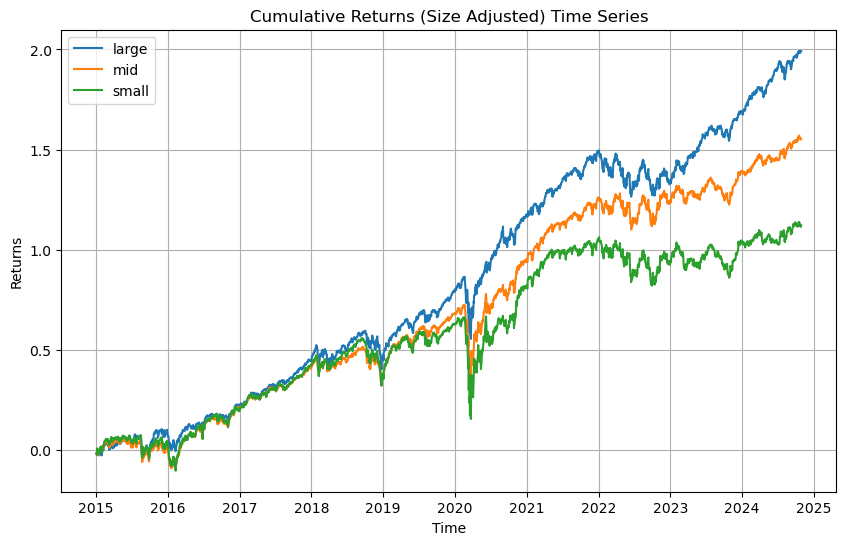

In [192]:
plt.figure(figsize=(10, 6))
plt.plot(size_portfolio_returns.cumsum(), label=size_portfolio_returns.columns, alpha=1)

# Config
plt.title('Cumulative Returns (Size Adjusted) Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [194]:
# Create DataFrames

size_portfolio_betas = size_decomposition(betas_df, mktcap_df)

size_portfolio_betas

,large,mid,small
Date,,,
2016-02-26,0.986693,0.972199,1.036178
2016-02-29,0.987261,0.979129,1.036289
2016-03-01,0.991016,0.980162,1.027821
2016-03-02,0.992361,0.988097,1.013019
2016-03-03,0.992211,0.990395,1.014398
...,...,...,...
2024-10-22,1.098369,0.680199,0.777216
2024-10-23,1.092739,0.676535,0.775221
2024-10-24,1.102285,0.674040,0.761440


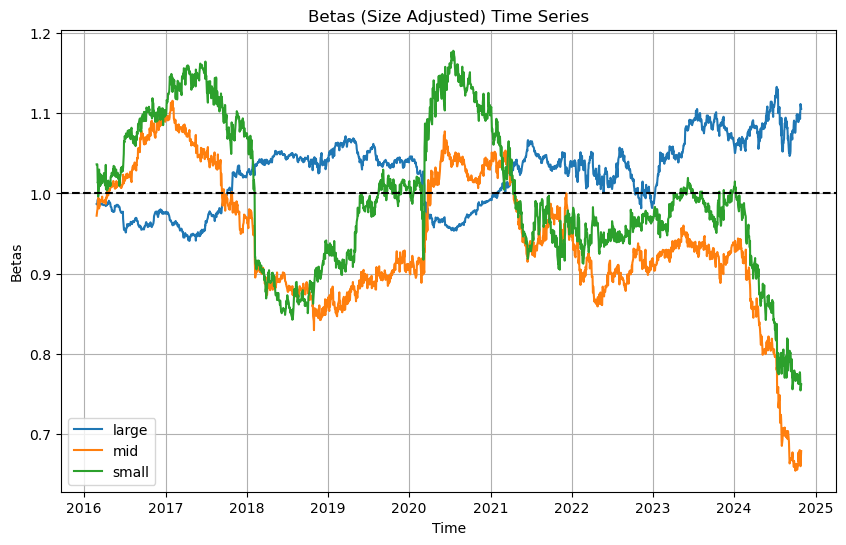

In [198]:
plt.figure(figsize=(10, 6))
plt.plot(size_portfolio_betas, label=size_portfolio_betas.columns, alpha=1)
plt.axhline(y=1, color='black', linestyle='dashed')

# Config
plt.title('Betas (Size Adjusted) Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()
plt.grid()

# Show
plt.show()

In [216]:
# Create the data
daily_rfr = (((1 + (rfr['risk_free_rate'].div(100)))**(1/360)) - 1)
benchmark_returns = sp500['sp_500'].pct_change(1)

# Create the Excess Returns
market_excess_returns = benchmark_returns - daily_rfr

In [220]:
# Create the regression dataframe
regression_df = pd.DataFrame(index = size_portfolio_returns.index)

regression_df['large_excess_returns'] = size_portfolio_returns['large'] - daily_rfr
regression_df['mid_excess_returns'] = size_portfolio_returns['mid'] - daily_rfr
regression_df['small_excess_returns'] = size_portfolio_returns['small'] - daily_rfr
regression_df['market_excess_returns'] = market_excess_returns
regression_df.dropna(inplace = True)

regression_df

,large_excess_returns,mid_excess_returns,small_excess_returns,market_excess_returns
Date,,,,
2015-02-24,0.002913,0.001068,0.002482,0.002704
2015-02-25,-0.000820,-0.000843,-0.000236,-0.000820
2015-02-26,0.000047,-0.001846,-0.004031,-0.001532
2015-02-27,-0.003706,-0.001373,-0.003520,-0.003011
2015-03-02,0.006071,0.005087,0.007380,0.006068
...,...,...,...,...
2024-10-22,0.001330,-0.002528,-0.006953,-0.000589
2024-10-23,-0.010856,-0.003921,-0.001127,-0.009307
2024-10-24,0.005272,-0.001411,0.000231,0.002031


In [222]:
# Calculate the Beta for the Large Portfolio

y = regression_df['large_excess_returns']

x = regression_df['market_excess_returns']
x = sm.add_constant(x)

# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model = sm.WLS(
    y, 
    x,
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary())   

                             WLS Regression Results                             
Dep. Variable:     large_excess_returns   R-squared:                       0.974
Model:                              WLS   Adj. R-squared:                  0.974
Method:                   Least Squares   F-statistic:                 9.106e+04
Date:                  Sat, 29 Mar 2025   Prob (F-statistic):               0.00
Time:                          13:27:01   Log-Likelihood:                 11660.
No. Observations:                  2420   AIC:                        -2.332e+04
Df Residuals:                      2418   BIC:                        -2.330e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const     

In [224]:
# Calculate the Beta for the Mid Portfolio

y = regression_df['mid_excess_returns']

x = regression_df['market_excess_returns']
x = sm.add_constant(x)

# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model = sm.WLS(
    y, 
    x,
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary())   

                            WLS Regression Results                            
Dep. Variable:     mid_excess_returns   R-squared:                       0.894
Model:                            WLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                 2.029e+04
Date:                Sat, 29 Mar 2025   Prob (F-statistic):               0.00
Time:                        13:27:48   Log-Likelihood:                 10016.
No. Observations:                2420   AIC:                        -2.003e+04
Df Residuals:                    2418   BIC:                        -2.002e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00

In [226]:
# Calculate the Beta for the Small Portfolio

y = regression_df['small_excess_returns']

x = regression_df['market_excess_returns']
x = sm.add_constant(x)

# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model = sm.WLS(
    y, 
    x,
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary())   

                             WLS Regression Results                             
Dep. Variable:     small_excess_returns   R-squared:                       0.809
Model:                              WLS   Adj. R-squared:                  0.809
Method:                   Least Squares   F-statistic:                 1.023e+04
Date:                  Sat, 29 Mar 2025   Prob (F-statistic):               0.00
Time:                          13:28:10   Log-Likelihood:                 9000.5
No. Observations:                  2420   AIC:                        -1.800e+04
Df Residuals:                      2418   BIC:                        -1.799e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const     

In [241]:
# Calculate the Small Minus Big Premium

regression_df['SMB'] = size_portfolio_returns['small'] - size_portfolio_returns['large']

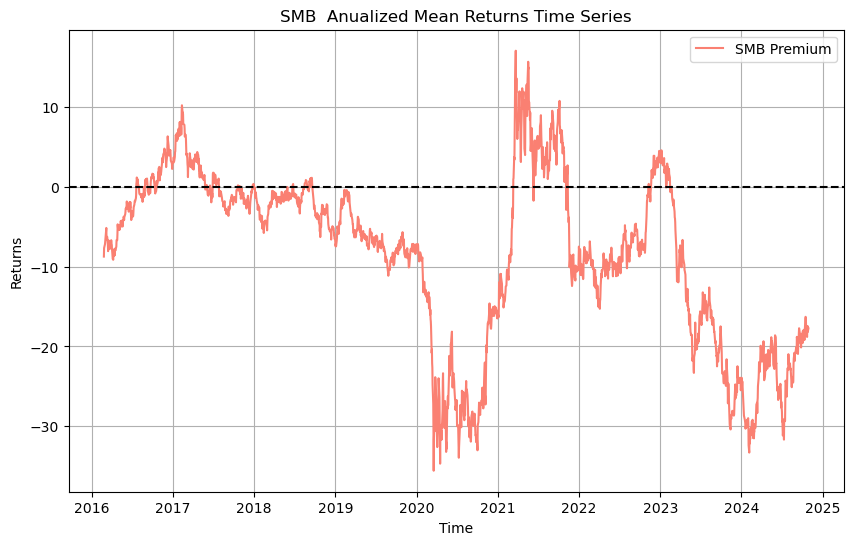

In [259]:
plt.figure(figsize=(10, 6))
plt.plot(regression_df['SMB'].mul(100).rolling(window=252).mean().mul(252), label='SMB Premium', color = 'salmon', alpha=1)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('SMB  Anualized Mean Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [245]:
#regression_df['SMB'].to_csv(r"..\additional_data\SMB.csv")

In [249]:
# Check the Correlation with the Market

regression_df['SMB'].corr(regression_df['market_excess_returns'])

0.03819303001710839

In [251]:
# Calculate the Beta for the SMB Premium

y = regression_df['SMB']

x = regression_df['market_excess_returns']
x = sm.add_constant(x)

# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model = sm.WLS(
    y, 
    x,
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary())   

                            WLS Regression Results                            
Dep. Variable:                    SMB   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2111
Date:                Sat, 29 Mar 2025   Prob (F-statistic):              0.646
Time:                        14:00:07   Log-Likelihood:                 8384.1
No. Observations:                2420   AIC:                        -1.676e+04
Df Residuals:                    2418   BIC:                        -1.675e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00